# Scoreboard Dashboard

The live scoreboard has changed the way fans follow basketball. Now, instead of needing to watch a game, fans have the option of following games through live scoreboards on several platforms. The [NBA](https://www.nba.com/games/20190104/UTACLE#/pbp) and [WNBA](https://www.wnba.com/game/20180711/NYLCON/#/play-by-play) sites have their own, along with many third party sites.

Through the [stats.nba.com](https://stats.nba.com) API, the information that powers these scoreboards is available. This notebook contains an introduction to the `scoreboardv2` endpoint of the API through the `ScoreBoard` class in the `py_ball` package. The goal is to leverage the power of Jupyter notebooks to build a prototype live scoreboard.

In [8]:
from io import BytesIO
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
import time

from py_ball import scoreboard, image

HEADERS = {'Connection': 'close',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'Referer': 'stats.nba.com',
           'x-nba-stats-origin': 'stats',
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_2)' + \
                         'AppleWebKit/537.36 (KHTML, like Gecko) ' + \
                         'Chrome/66.0.3359.117 Safari/537.36'}

pd.options.mode.chained_assignment = None  # Disabling pandas SetWithCopyWarnings

The `ScoreBoard` class requires three parameters:
- league_id: One of '00' (NBA) or '10' (WNBA)
- game_date: String of date in 'MM/DD/YYYY' corresponding to the day for which data is desired
- day_offset: String of an integer representing days from or before the date given in game_date for which data is desired. Positive values indicate days into the future, zero represents the current day, and negative values indicate days into the past

In [9]:
league_id = '00' #WNBA
game_date = '11/07/2019'
day_offset = '0'

scores = scoreboard.ScoreBoard(headers=HEADERS,
                               endpoint='scoreboardv2',
                               league_id=league_id,
                               game_date=game_date,
                               day_offset=day_offset)

scores.data.keys()

dict_keys(['GameHeader', 'LineScore', 'SeriesStandings', 'LastMeeting', 'EastConfStandingsByDay', 'WestConfStandingsByDay', 'Available', 'TeamLeaders', 'TicketLinks', 'WinProbability'])

The above shows the tables available from this endpoint. For the scoreboard, the `LineScore` table should contain most of the data needed.

In [10]:
scoreboard_df = pd.DataFrame(scores.data['GameHeader'])
list(scoreboard_df.head(15))

['GAME_DATE_EST',
 'GAME_SEQUENCE',
 'GAME_ID',
 'GAME_STATUS_ID',
 'GAME_STATUS_TEXT',
 'GAMECODE',
 'HOME_TEAM_ID',
 'VISITOR_TEAM_ID',
 'SEASON',
 'LIVE_PERIOD',
 'LIVE_PC_TIME',
 'NATL_TV_BROADCASTER_ABBREVIATION',
 'HOME_TV_BROADCASTER_ABBREVIATION',
 'AWAY_TV_BROADCASTER_ABBREVIATION',
 'LIVE_PERIOD_TIME_BCAST',
 'ARENA_NAME',
 'WH_STATUS']

In [11]:
pd.DataFrame(scores.data['GameHeader']).T

,0,1,2,3
GAME_DATE_EST,2019-11-07T00:00:00,2019-11-07T00:00:00,2019-11-07T00:00:00,2019-11-07T00:00:00
GAME_SEQUENCE,1,2,3,4
GAME_ID,0021900112,0021900113,0021900114,0021900115
GAME_STATUS_ID,3,3,3,3
GAME_STATUS_TEXT,Final,Final,Final,Final
GAMECODE,20191107/BOSCHA,20191107/OKCSAS,20191107/MIAPHX,20191107/PORLAC
HOME_TEAM_ID,1610612766,1610612759,1610612756,1610612746
VISITOR_TEAM_ID,1610612738,1610612760,1610612748,1610612757
SEASON,2019,2019,2019,2019
LIVE_PERIOD,4,4,4,4


The `scoreboard_df` contains some game metadata and team performance, including points by period (the table schema has fields to handle games with up to 10 overtime periods!). Additionally, each row in `scoreboard_df` corresponds to a team, not a game. However, the current time and period are not available in this DataFrame. The cell below checks the `GameHeader` table for this information.

In [19]:
game_header_df = pd.DataFrame(scores.data['GameHeader'])
game_header_df.head(5).T

,0
ARENA_NAME,Mandalay Bay Events Center
AWAY_TV_BROADCASTER_ABBREVIATION,None
GAMECODE,20190727/EDDWIL
GAME_DATE_EST,2019-07-27T00:00:00
GAME_ID,1031900001
GAME_SEQUENCE,1
GAME_STATUS_ID,3
GAME_STATUS_TEXT,Final
HOME_TEAM_ID,1611665410
HOME_TV_BROADCASTER_ABBREVIATION,None


The `game_header_df` has the period and game time information available (columns: `LIVE_PC_TIME`, `LIVE_PERIOD`, `LIVE_PERIOD_TIME_BCAST`). With all of the above information at disposal, the list below gives some ideas for features to include on the scoreboard:
- Team logos
- Live period, time, and points
- Live team totals for other statistics
- Boxscore for team points by period

While the scoreboard can include much more information, starting with this list should provide a good foundation.

In [20]:
def pull_game_data(game_id, count=0):
    """ pull_game_data gathers the data needed to create
    a scoreboard for the game identified by game_id

    @param game_id (str): Unique game identifier
    @param count (int): integer controlling the
        number of 'day_offset' values are fed to
        the API. This is a hack to ensure the
        data refreshes

    Returns:

        team_df (DataFrame): DataFrame containing
            team performance data
        game_df (DataFrame): DataFrame containing
            game metadata and live period/time
        away_team_logo (PngImageFile): PNG object of away team
            logo
        home_team_logo (PngImageFile): PNG object of home team
            logo
    """

    if count > 0:
        day_list = [day_offset]*count
    else:
        day_list = day_offset
            
    scores = scoreboard.ScoreBoard(headers=HEADERS,
                               endpoint='scoreboardv2',
                               league_id=league_id,
                               game_date=game_date,
                               day_offset=day_list)

    scores_df = pd.DataFrame(scores.data['LineScore'])
    header_df = pd.DataFrame(scores.data['GameHeader'])

    if game_id not in list(scores_df['GAME_ID']):
        print('Game ' + game_id + ' not available for date and league provided')

    team_df = scores_df[scores_df['GAME_ID']==game_id]
    game_df = header_df[header_df['GAME_ID']==game_id]
    team_df['FULL_NAME'] = team_df['TEAM_CITY_NAME'] + ' ' + team_df['TEAM_NAME']

    away_team = game_df['VISITOR_TEAM_ID'].iloc[0]
    home_team = game_df['HOME_TEAM_ID'].iloc[0]

    if league_id == '00':
        league = 'NBA'
    elif league_id == '10':
        league = 'WNBA'
    else:
        league = 'G'

#     away_team_logo = image.Logo(league=league,
#                                 team_id=str(away_team))
#     home_team_logo = image.Logo(league=league,
#                                 team_id=str(home_team))

    if game_df['GAME_STATUS_ID'].iloc[0] != 1:
        team_df['FG3_PCT'] = 100*team_df['FG3_PCT']
        team_df['FG_PCT'] = 100*team_df['FG_PCT']
        team_df['AST'] = [int(x) for x in team_df['AST']]
        team_df['REB'] = [int(x) for x in team_df['REB']]
        team_df['TOV'] = [int(x) for x in team_df['TOV']]

    return team_df, game_df, away_team_logo.image, home_team_logo.image, [away_team, home_team]

In [21]:
team_df, game_df, away_team_logo, home_team_logo, team_ids = pull_game_data('2021800139')

Game 1611665409 not available for date and league provided


IndexError: single positional indexer is out-of-bounds

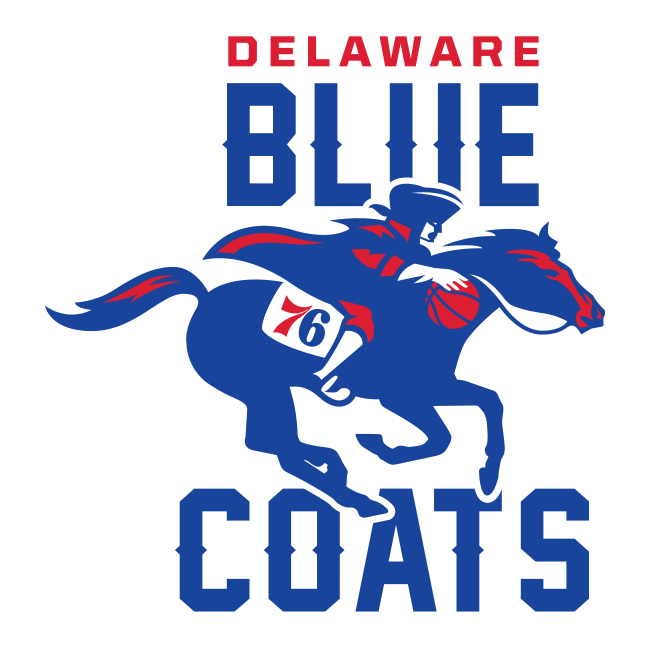

In [8]:
away_team_logo

Structuring `pull_game_data` in this manner allows refreshed game data to be pulled given a `GAME_ID`, which is crucial for any scoreboard.

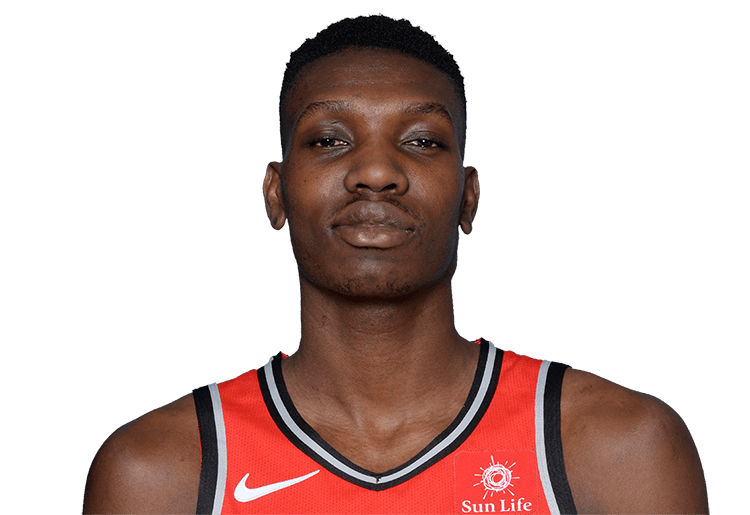

In [9]:
image.Headshot(league='G', player_id='1628449').image

In [9]:
def build_scoreboard(game_id, count=0):
    """ build_scoreboard generates a scoreboard dashboard
    for the game identified by game_id
    """

    team_df, game_df, away_team_logo, home_team_logo, team_ids = pull_game_data(game_id, count)
    away_team_id, home_team_id = team_ids

    # Away logo display
    away_bytes = BytesIO()
    away_team_logo.save(away_bytes, format='PNG')
    away_bytes = away_bytes.getvalue()

    away_logo_widget  = widgets.Image(value=away_bytes,
                                      format='png',
                                      width=128,
                                      height=128)

    # Home logo display
    home_bytes = BytesIO()
    home_team_logo.save(home_bytes, format='PNG')
    home_bytes = home_bytes.getvalue()

    home_logo_widget = widgets.Image(value=home_bytes,
                                      format='png',
                                      width=128,
                                      height=128)

    # Game metadata widgets: Team names, scores, game time and status
    away_df = team_df[team_df['TEAM_ID']==away_team_id]
    home_df = team_df[team_df['TEAM_ID']==home_team_id]
    away_name = away_df['FULL_NAME'].iloc[0]
    home_name = home_df['FULL_NAME'].iloc[0]

    away_name_widget = widgets.HTML(value='<font size="2">' + away_name + '</font>',
                                    layout=widgets.Layout(flex='auto', width='auto'))
    home_name_widget = widgets.HTML(value='<font size="2">' +  home_name + '</font>',
                                    layout=widgets.Layout(flex='auto', width='auto'))

    status = game_df['GAME_STATUS_ID'].iloc[0]
    if status != 1:
        away_score_widget = widgets.HTML(value='<font size="5"><b>' +
                                               str(int(away_df['PTS'].iloc[0])) + '</b></font>',
                                         layout=widgets.Layout(flex='auto', width='auto'))
        home_score_widget = widgets.HTML(value='<font size="5"><b>' +
                                               str(int(home_df['PTS'].iloc[0])) + '</b></font>',
                                         layout=widgets.Layout(flex='auto', width='auto'))
    else:
        away_score_widget = widgets.HTML(value='<font size="5"><b>' +
                                               str(0) + '</b></font>',
                                         layout=widgets.Layout(flex='auto', width='auto'))
        home_score_widget = widgets.HTML(value='<font size="5"><b>' +
                                               str(0) + '</b></font>',
                                         layout=widgets.Layout(flex='auto', width='auto'))
    
    game_time = widgets.HTML(value='<font size="3"><b>' +
                                   str(game_df['LIVE_PERIOD_TIME_BCAST'].iloc[0]) + '</b></font>',
                             layout=widgets.Layout(flex='auto', width='auto'))
    game_status = widgets.HTML(value='<font size="3"><b>' +
                                   str(game_df['GAME_STATUS_TEXT'].iloc[0]) + '</b></font>',
                             layout=widgets.Layout(flex='auto', width='auto'))
    space = widgets.HTML(value='<font size="3">&emsp;&emsp;&emsp;&emsp;&emsp;</font>',
                         layout=widgets.Layout(flex='auto', width='auto'))

    # Score by period table generation
    period = game_df['LIVE_PERIOD'].iloc[0]
    points_list = ['PTS_QTR1', 'PTS_QTR2', 'PTS_QTR3', 'PTS_QTR4']
    label_list = ['1', '2', '3', '4']

    if period >= 5:
        for ot in range(5, period+1):
            points_list.append('PTS_OT' + str(ot))
            label_list.append('OT' + str(ot))

    away_points = away_df[points_list]
    home_points = home_df[points_list]

    points_df = away_points.append(home_points)
    points_df.columns = label_list

    points_df.index = [away_name, home_name]

    away_df = away_df[['FG3_PCT', 'FG_PCT', 'AST', 'REB', 'TOV']].T
    home_df = home_df[['FG3_PCT', 'FG_PCT', 'AST', 'REB', 'TOV']].T
    away_df.columns = [away_name]
    home_df.columns = [home_name]

    # Layout widgets to control the structure of the output
    logo_layout = widgets.Layout(display='flex',
                                 flex_flow='row',
                                 align_items='center',
                                 justify_content='space-between',
                                 width='50%')
    name_layout = widgets.Layout(display='flex',
                                 flex_flow='column',
                                 align_items='center',
                                 justify_content='center',
                                 width='100%')

    dash_layout = widgets.Layout(display='flex',
                                 flex_flow='column',
                                 align_items='center',
                                 justify_content='center',
                                 width='50%')

    # Stacking output widgets horizontally and vertically
    away_names = widgets.VBox([away_name_widget, away_score_widget], layout=name_layout)
    home_names = widgets.VBox([home_name_widget, home_score_widget], layout=name_layout)
    game_meta_data = widgets.VBox([game_time, game_status], layout=dash_layout)

    # Performance and points scored by team
    away_out = widgets.Output(layout=widgets.Layout(flex='flex', width='100%'))
    with away_out:
        clear_output(wait=True)
        display(away_df)

    home_out = widgets.Output(layout=widgets.Layout(flex='flex', width='100%'))
    with home_out:
        clear_output(wait=True)
        display(home_df)

    pts_out = widgets.Output(layout=widgets.Layout(flex='flex', width='100%'))
    with pts_out:
        clear_output(wait=True)
        display(points_df)
        
    away_box = widgets.VBox([away_logo_widget, away_names, away_out], layout=dash_layout)
    home_box = widgets.VBox([home_logo_widget, home_names, home_out], layout=dash_layout)

    scoreboard_widget = widgets.HBox([away_box, home_box], layout=logo_layout)
    dashboard_widget = widgets.VBox([scoreboard_widget, widgets.HBox([space, pts_out])])

    return status, game_meta_data, dashboard_widget

In [10]:
game_id = '1021900106'

In [14]:
%matplotlib inline

out = widgets.Output()

game_status = 0
count = 10
# game_status of 3 means that the game is over,
# so this while loop will refresh the scoreboard
# widget every thirty seconds
while game_status != 3:
    count += 1
    if count > 300:
        count = 0
    game_status, game_meta_data, dashboard_widget = build_scoreboard(game_id, count)
    with out:
        display(game_meta_data, dashboard_widget)
    time.sleep(30)
    game_meta_data.close()
    dashboard_widget.close()

## Exploration

- What other information would be useful to add to the scoreboard? Can you study the ipywidget code and add something to the scoreboard?
- Can you alter the final cell here to display multiple games?
- Try adding a player leaderboard for certain statistical categories.

In [7]:
dist_map = {1610612737: {1610612737: 0, # ATL
                         1610612738: 937, # BOS
                         1610612751: 748, # BRK
                         1610612766: 226, # CHA
                         1610612741: 589, # CHI
                         1610612739: 556, # CLE
                         1610612742: 720, # DAL
                         1610612743: 1211, # DEN
                         1610612765: 598, # DET
                         1610612744: 2130, # GSW
                         1610612745: 702, # HOU
                         1610612754: 428, # IND
                         1610612746: 1935, # LAC
                         1610612747: 1935, # LAL
                         1610612763: 337, # MEM
                         1610612748: 607, # MIA
                         1610612749: 670, # MIL
                         1610612750: 909, # MIN
                         1610612740: 425, # NOP
                         1610612752: 749, # NYK
                         1610612760: 756, # OKC
                         1610612753: 402, # ORL
                         1610612755: 666, # PHI
                         1610612756: 1587, # PHX
                         1610612757: 2171, # POR
                         1610612758: 2085, # SAC
                         1610612759: 882, # SAS
                         1610612761: 736, # TOR
                         1610612762: 1582, # UTA
                         1610612764: 543},
           1610612738: {1610612737: 937, # ATL
                         1610612738: 0, # BOS
                         1610612751: 189, # BRK
                         1610612766: 721, # CHA
                         1610612741: 850, # CHI
                         1610612739: 550, # CLE
                         1610612742: 1551, # DAL
                         1610612743: 1767, # DEN
                         1610612765: 612, # DET
                         1610612744: 2688, # GSW
                         1610612745: 1606, # HOU
                         1610612754: 806, # IND
                         1610612746: 2594, # LAC
                         1610612747: 2594, # LAL
                         1610612763: 1136, # MEM
                         1610612748: 1260, # MIA
                         1610612749: 856, # MIL
                         1610612750: 1122, # MIN
                         1610612740: 1360, # NOP
                         1610612752: 188, # NYK
                         1610612760: 1494, # OKC
                         1610612753: 1117, # ORL
                         1610612755: 271, # PHI
                         1610612756: 2298, # PHX
                         1610612757: 2536, # POR
                         1610612758: 2628, # SAC
                         1610612759: 1767, # SAS
                         1610612761: 430, # TOR
                         1610612762: 2096, # UTA
                         1610612764: 394},
            1610612751: {1610612737: 748, # ATL
                         1610612738: 189, # BOS
                         1610612751: 0, # BRK
                         1610612766: 394, # CHA
                         1610612741: 715, # CHI
                         1610612739: 408, # CLE
                         1610612742: 1375, # DAL
                         1610612743: 1633, # DEN
                         1610612765: 485, # DET
                         1610612744: 2564, # GSW
                         1610612745: 1421, # HOU
                         1610612754: 648, # IND
                         1610612746: 2452, # LAC
                         1610612747: 2452, # LAL
                         1610612763: 957, # MEM
                         1610612748: 1093, # MIA
                         1610612749: 737, # MIL
                         1610612750: 1021, # MIN
                         1610612740: 1171, # NOP
                         1610612752: 6, # NYK
                         1610612760: 1329, # OKC
                         1610612753: 939, # ORL
                         1610612755: 82, # PHI
                         1610612756: 2145, # PHX
                         1610612757: 2446, # POR
                         1610612758: 2506, # SAC
                         1610612759: 1585, # SAS
                         1610612761: 346, # TOR
                         1610612762: 1974, # UTA
                         1610612764: 205},
           1610612766: {1610612737: 226, # ATL
                         1610612738: 721, # BOS
                         1610612751: 394, # BRK
                         1610612766: 0, # CHA
                         1610612741: 588, # CHI
                         1610612739: 436, # CLE
                         1610612742: 929, # DAL
                         1610612743: 1357, # DEN
                         1610612765: 506, # DET
                         1610612744: 2291, # GSW
                         1610612745: 927, # HOU
                         1610612754: 428, # IND
                         1610612746: 2117, # LAC
                         1610612747: 2117, # LAL
                         1610612763: 520, # MEM
                         1610612748: 656, # MIA
                         1610612749: 659, # MIL
                         1610612750: 940, # MIN
                         1610612740: 649, # NOP
                         1610612752: 534, # NYK
                         1610612760: 940, # OKC
                         1610612753: 464, # ORL
                         1610612755: 451, # PHI
                         1610612756: 1781, # PHX
                         1610612757: 2287, # POR
                         1610612758: 2242, # SAC
                         1610612759: 1105, # SAS
                         1610612761: 588, # TOR
                         1610612762: 1726, # UTA
                         1610612764: 330},
           1610612741: {1610612737: 589, # ATL
                         1610612738: 850, # BOS
                         1610612751: 715, # BRK
                         1610612766: 588, # CHA
                         1610612741: 0, # CHI
                         1610612739: 308, # CLE
                         1610612742: 806, # DAL
                         1610612743: 919, # DEN
                         1610612765: 237, # DET
                         1610612744: 1849, # GSW
                         1610612745: 943, # HOU
                         1610612754: 165, # IND
                         1610612746: 1744, # LAC
                         1610612747: 1744, # LAL
                         1610612763: 483, # MEM
                         1610612748: 1193, # MIA
                         1610612749: 82, # MIL
                         1610612750: 355, # MIN
                         1610612740: 836, # NOP
                         1610612752: 712, # NYK
                         1610612760: 693, # OKC
                         1610612753: 987, # ORL
                         1610612755: 664, # PHI
                         1610612756: 1453, # PHX
                         1610612757: 1756, # POR
                         1610612758: 1791, # SAC
                         1610612759: 1054, # SAS
                         1610612761: 436, # TOR
                         1610612762: 1259, # UTA
                         1610612764: 594},
           1610612739: {1610612737: 556, # ATL
                         1610612738: 550, # BOS
                         1610612751: 408, # BRK
                         1610612766: 436, # CHA
                         1610612741: 308, # CHI
                         1610612739: 0, # CLE
                         1610612742: 1026, # DAL
                         1610612743: 1225, # DEN
                         1610612765: 90, # DET
                         1610612744: 2156, # GSW
                         1610612745: 1115, # HOU
                         1610612754: 263, # IND
                         1610612746: 2047, # LAC
                         1610612747: 2047, # LAL
                         1610612763: 634, # MEM
                         1610612748: 1092, # MIA
                         1610612749: 335, # MIL
                         1610612750: 630, # MIN
                         1610612740: 926, # NOP
                         1610612752: 404, # NYK
                         1610612760: 951, # OKC
                         1610612753: 897, # ORL
                         1610612755: 358, # PHI
                         1610612756: 1748, # PHX
                         1610612757: 2052, # POR
                         1610612758: 2099, # SAC
                         1610612759: 1258, # SAS
                         1610612761: 190, # TOR
                         1610612762: 1566, # UTA
                         1610612764: 304},
           1610612742: {1610612737: 720, # ATL
                         1610612738: 1551, # BOS
                         1610612751: 1375, # BRK
                         1610612766: 929, # CHA
                         1610612741: 806, # CHI
                         1610612739: 1026, # CLE
                         1610612742: 0, # DAL
                         1610612743: 663, # DEN
                         1610612765: 1000, # DET
                         1610612744: 1475, # GSW
                         1610612745: 225, # HOU
                         1610612754: 764, # IND
                         1610612746: 1239, # LAC
                         1610612747: 1239, # LAL
                         1610612763: 420, # MEM
                         1610612748: 1111, # MIA
                         1610612749: 859, # MIL
                         1610612750: 865, # MIN
                         1610612740: 443, # NOP
                         1610612752: 1373, # NYK
                         1610612760: 191, # OKC
                         1610612753: 962, # ORL
                         1610612755: 1299, # PHI
                         1610612756: 886, # PHX
                         1610612757: 1633, # POR
                         1610612758: 1440, # SAC
                         1610612759: 253, # SAS
                         1610612761: 1205, # TOR
                         1610612762: 1000, # UTA
                         1610612764: 1183},
           1610612743: {1610612737: 1211, # ATL
                         1610612738: 1767, # BOS
                         1610612751: 1633, # BRK
                         1610612766: 1357, # CHA
                         1610612741: 919, # CHI
                         1610612739: 1225, # CLE
                         1610612742: 663, # DAL
                         1610612743: 0, # DEN
                         1610612765: 1156, # DET
                         1610612744: 940, # GSW
                         1610612745: 879, # HOU
                         1610612754: 1000, # IND
                         1610612746: 831, # LAC
                         1610612747: 831, # LAL
                         1610612763: 878, # MEM
                         1610612748: 1727, # MIA
                         1610612749: 914, # MIL
                         1610612750: 699, # MIN
                         1610612740: 1082, # NOP
                         1610612752: 1630, # NYK
                         1610612760: 505, # OKC
                         1610612753: 1551, # ORL
                         1610612755: 1577, # PHI
                         1610612756: 586, # PHX
                         1610612757: 982, # POR
                         1610612758: 888, # SAC
                         1610612759: 803, # SAS
                         1610612761: 1344, # TOR
                         1610612762: 371, # UTA
                         1610612764: 1491},
           1610612765: {1610612737: 598, # ATL
                         1610612738: 612, # BOS
                         1610612751: 485, # BRK
                         1610612766: 506, # CHA
                         1610612741: 237, # CHI
                         1610612739: 90, # CLE
                         1610612742: 1000, # DAL
                         1610612743: 1156, # DEN
                         1610612765: 0, # DET
                         1610612744: 2081, # GSW
                         1610612745: 1107, # HOU
                         1610612754: 240, # IND
                         1610612746: 1982, # LAC
                         1610612747: 1982, # LAL
                         1610612763: 624, # MEM
                         1610612748: 1158, # MIA
                         1610612749: 252, # MIL
                         1610612750: 543, # MIN
                         1610612740: 941, # NOP
                         1610612752: 481, # NYK
                         1610612760: 910, # OKC
                         1610612753: 959, # ORL
                         1610612755: 442, # PHI
                         1610612756: 1689, # PHX
                         1610612757: 1966, # POR
                         1610612758: 2023, # SAC
                         1610612759: 1240, # SAS
                         1610612761: 207, # TOR
                         1610612762: 1490, # UTA
                         1610612764: 394},
           1610612744: {1610612737: 2130, # ATL
                         1610612738: 2688, # BOS
                         1610612751: 2564, # BRK
                         1610612766: 2291, # CHA
                         1610612741: 1849, # CHI
                         1610612739: 2156, # CLE
                         1610612742: 1475, # DAL
                         1610612743: 940, # DEN
                         1610612765: 2081, # DET
                         1610612744: 0, # GSW
                         1610612745: 1637, # HOU
                         1610612754: 1939, # IND
                         1610612746: 344, # LAC
                         1610612747: 344, # LAL
                         1610612763: 1793, # MEM
                         1610612748: 2586, # MIA
                         1610612749: 1832, # MIL
                         1610612750: 1575, # MIN
                         1610612740: 1917, # NOP
                         1610612752: 2560, # NYK
                         1610612760: 1379, # OKC
                         1610612753: 2432, # ORL
                         1610612755: 2511, # PHI
                         1610612756: 647, # PHX
                         1610612757: 534, # POR
                         1610612758: 68, # SAC
                         1610612759: 1482, # SAS
                         1610612761: 2258, # TOR
                         1610612762: 592, # UTA
                         1610612764: 2429},
           1610612745: {1610612737: 702, # ATL
                         1610612738: 1606, # BOS
                         1610612751: 1421, # BRK
                         1610612766: 927, # CHA
                         1610612741: 943, # CHI
                         1610612739: 1115, # CLE
                         1610612742: 225, # DAL
                         1610612743: 879, # DEN
                         1610612765: 1107, # DET
                         1610612744: 1637, # GSW
                         1610612745: 0, # HOU
                         1610612754: 867, # IND
                         1610612746: 1372, # LAC
                         1610612747: 1372, # LAL
                         1610612763: 485, # MEM
                         1610612748: 968, # MIA
                         1610612749: 1007, # MIL
                         1610612750: 1059, # MIN
                         1610612740: 318, # NOP
                         1610612752: 1421, # NYK
                         1610612760: 414, # OKC
                         1610612753: 849, # ORL
                         1610612755: 1341, # PHI
                         1610612756: 1015, # PHX
                         1610612757: 1836, # POR
                         1610612758: 1608, # SAC
                         1610612759: 189, # SAS
                         1610612761: 1303, # TOR
                         1610612762: 1200, # UTA
                         1610612764: 1220},
           1610612754: {1610612737: 428, # ATL
                         1610612738: 806, # BOS
                         1610612751: 648, # BRK
                         1610612766: 428, # CHA
                         1610612741: 165, # CHI
                         1610612739: 263, # CLE
                         1610612742: 764, # DAL
                         1610612743: 1000, # DEN
                         1610612765: 240, # DET
                         1610612744: 1939, # GSW
                         1610612745: 867, # HOU
                         1610612754: 0, # IND
                         1610612746: 1808, # LAC
                         1610612747: 1808, # LAL
                         1610612763: 384, # MEM
                         1610612748: 1028, # MIA
                         1610612749: 244, # MIL
                         1610612750: 511, # MIN
                         1610612740: 714, # NOP
                         1610612752: 645, # NYK
                         1610612760: 689, # OKC
                         1610612753: 823, # ORL
                         1610612755: 583, # PHI
                         1610612756: 1498, # PHX
                         1610612757: 1883, # POR
                         1610612758: 1884, # SAC
                         1610612759: 1001, # SAS
                         1610612761: 441, # TOR
                         1610612762: 1355, # UTA
                         1610612764: 491},
           1610612746: {1610612737: 1935, # ATL
                         1610612738: 2594, # BOS
                         1610612751: 2452, # BRK
                         1610612766: 2117, # CHA
                         1610612741: 1744, # CHI
                         1610612739: 2047, # CLE
                         1610612742: 1239, # DAL
                         1610612743: 831, # DEN
                         1610612765: 1982, # DET
                         1610612744: 344, # GSW
                         1610612745: 1372, # HOU
                         1610612754: 1808, # IND
                         1610612746: 0, # LAC
                         1610612747: 0, # LAL
                         1610612763: 1602, # MEM
                         1610612748: 2338, # MIA
                         1610612749: 1743, # MIL
                         1610612750: 1523, # MIN
                         1610612740: 1671, # NOP
                         1610612752: 2449, # NYK
                         1610612760: 1180, # OKC
                         1610612753: 2200, # ORL
                         1610612755: 2391, # PHI
                         1610612756: 357, # PHX
                         1610612757: 827, # POR
                         1610612758: 362, # SAC
                         1610612759: 1203, # SAS
                         1610612761: 2174, # TOR
                         1610612762: 580, # UTA
                         1610612764: 2297},
           1610612747: {1610612737: 1935, # ATL
                         1610612738: 2594, # BOS
                         1610612751: 2452, # BRK
                         1610612766: 2117, # CHA
                         1610612741: 1744, # CHI
                         1610612739: 2047, # CLE
                         1610612742: 1239, # DAL
                         1610612743: 831, # DEN
                         1610612765: 1982, # DET
                         1610612744: 344, # GSW
                         1610612745: 1372, # HOU
                         1610612754: 1808, # IND
                         1610612746: 0, # LAC
                         1610612747: 0, # LAL
                         1610612763: 1602, # MEM
                         1610612748: 2338, # MIA
                         1610612749: 1743, # MIL
                         1610612750: 1523, # MIN
                         1610612740: 1671, # NOP
                         1610612752: 2449, # NYK
                         1610612760: 1180, # OKC
                         1610612753: 2200, # ORL
                         1610612755: 2391, # PHI
                         1610612756: 357, # PHX
                         1610612757: 827, # POR
                         1610612758: 362, # SAC
                         1610612759: 1203, # SAS
                         1610612761: 2174, # TOR
                         1610612762: 580, # UTA
                         1610612764: 2297},
           1610612763: {1610612737: 337, # ATL
                         1610612738: 1136, # BOS
                         1610612751: 957, # BRK
                         1610612766: 520, # CHA
                         1610612741: 483, # CHI
                         1610612739: 634, # CLE
                         1610612742: 420, # DAL
                         1610612743: 878, # DEN
                         1610612765: 624, # DET
                         1610612744: 1793, # GSW
                         1610612745: 485, # HOU
                         1610612754: 384, # IND
                         1610612746: 1602, # LAC
                         1610612747: 1602, # LAL
                         1610612763: 0, # MEM
                         1610612748: 875, # MIA
                         1610612749: 558, # MIL
                         1610612750: 701, # MIN
                         1610612740: 360, # NOP
                         1610612752: 956, # NYK
                         1610612760: 422, # OKC
                         1610612753: 684, # ORL
                         1610612755: 880, # PHI
                         1610612756: 1261, # PHX
                         1610612757: 1848, # POR
                         1610612758: 1748, # SAC
                         1610612759: 633, # SAS
                         1610612761: 818, # TOR
                         1610612762: 1249, # UTA
                         1610612764: 763},
           1610612748: {1610612737: 607, # ATL
                         1610612738: 1260, # BOS
                         1610612751: 1093, # BRK
                         1610612766: 656, # CHA
                         1610612741: 1193, # CHI
                         1610612739: 1092, # CLE
                         1610612742: 1111, # DAL
                         1610612743: 1727, # DEN
                         1610612765: 1158, # DET
                         1610612744: 2586, # GSW
                         1610612745: 968, # HOU
                         1610612754: 1028, # IND
                         1610612746: 2338, # LAC
                         1610612747: 2338, # LAL
                         1610612763: 875, # MEM
                         1610612748: 0, # MIA
                         1610612749: 1272, # MIL
                         1610612750: 1516, # MIN
                         1610612740: 670, # NOP
                         1610612752: 1906, # NYK
                         1610612760: 1228, # OKC
                         1610612753: 205, # ORL
                         1610612755: 1024, # PHI
                         1610612756: 1981, # PHX
                         1610612757: 2708, # POR
                         1610612758: 2551, # SAC
                         1610612759: 1149, # SAS
                         1610612761: 1238, # TOR
                         1610612762: 2090, # UTA
                         1610612764: 928},
           1610612749: {1610612737: 670, # ATL
                         1610612738: 856, # BOS
                         1610612751: 737, # BRK
                         1610612766: 659, # CHA
                         1610612741: 82, # CHI
                         1610612739: 335, # CLE
                         1610612742: 859, # DAL
                         1610612743: 914, # DEN
                         1610612765: 252, # DET
                         1610612744: 1832, # GSW
                         1610612745: 1007, # HOU
                         1610612754: 244, # IND
                         1610612746: 1743, # LAC
                         1610612747: 1743, # LAL
                         1610612763: 558, # MEM
                         1610612748: 1272, # MIA
                         1610612749: 0, # MIL
                         1610612750: 298, # MIN
                         1610612740: 913, # NOP
                         1610612752: 733, # NYK
                         1610612760: 733, # OKC
                         1610612753: 1067, # ORL
                         1610612755: 693, # PHI
                         1610612756: 1464, # PHX
                         1610612757: 1717, # POR
                         1610612758: 1773, # SAC
                         1610612759: 1110, # SAS
                         1610612761: 431, # TOR
                         1610612762: 1241, # UTA
                         1610612764: 635},
           1610612750: {1610612737: 909, # ATL
                         1610612738: 1122, # BOS
                         1610612751: 1021, # BRK
                         1610612766: 940, # CHA
                         1610612741: 355, # CHI
                         1610612739: 630, # CLE
                         1610612742: 865, # DAL
                         1610612743: 699, # DEN
                         1610612765: 543, # DET
                         1610612744: 1575, # GSW
                         1610612745: 1059, # HOU
                         1610612754: 511, # IND
                         1610612746: 1523, # LAC
                         1610612747: 1523, # LAL
                         1610612763: 701, # MEM
                         1610612748: 1516, # MIA
                         1610612749: 298, # MIL
                         1610612750: 0, # MIN
                         1610612740: 1054, # NOP
                         1610612752: 1017, # NYK
                         1610612760: 695, # OKC
                         1610612753: 1311, # ORL
                         1610612755: 984, # PHI
                         1610612756: 1280, # PHX
                         1610612757: 1425, # POR
                         1610612758: 1513, # SAC
                         1610612759: 1113, # SAS
                         1610612761: 692, # TOR
                         1610612762: 986, # UTA
                         1610612764: 932},
           1610612740: {1610612737: 425, # ATL
                         1610612738: 1360, # BOS
                         1610612751: 1171, # BRK
                         1610612766: 649, # CHA
                         1610612741: 836, # CHI
                         1610612739: 926, # CLE
                         1610612742: 443, # DAL
                         1610612743: 1082, # DEN
                         1610612765: 941, # DET
                         1610612744: 1917, # GSW
                         1610612745: 318, # HOU
                         1610612754: 714, # IND
                         1610612746: 1671, # LAC
                         1610612747: 1671, # LAL
                         1610612763: 360, # MEM
                         1610612748: 670, # MIA
                         1610612749: 913, # MIL
                         1610612750: 1054, # MIN
                         1610612740: 0, # NOP
                         1610612752: 1172, # NYK
                         1610612760: 577, # OKC
                         1610612753: 534, # ORL
                         1610612755: 1090, # PHI
                         1610612756: 1315, # PHX
                         1610612757: 2062, # POR
                         1610612758: 1882, # SAC
                         1610612759: 507, # SAS
                         1610612761: 1115, # TOR
                         1610612762: 1434, # UTA
                         1610612764: 966},
           1610612752: {1610612737: 749, # ATL
                         1610612738: 188, # BOS
                         1610612751: 6, # BRK
                         1610612766: 534, # CHA
                         1610612741: 712, # CHI
                         1610612739: 404, # CLE
                         1610612742: 1373, # DAL
                         1610612743: 1630, # DEN
                         1610612765: 481, # DET
                         1610612744: 2560, # GSW
                         1610612745: 1421, # HOU
                         1610612754: 645, # IND
                         1610612746: 2449, # LAC
                         1610612747: 2449, # LAL
                         1610612763: 956, # MEM
                         1610612748: 1096, # MIA
                         1610612749: 733, # MIL
                         1610612750: 1017, # MIN
                         1610612740: 1172, # NOP
                         1610612752: 0, # NYK
                         1610612760: 1327, # OKC
                         1610612753: 943, # ORL
                         1610612755: 83, # PHI
                         1610612756: 2143, # PHX
                         1610612757: 2441, # POR
                         1610612758: 2503, # SAC
                         1610612759: 1585, # SAS
                         1610612761: 341, # TOR
                         1610612762: 1970, # UTA
                         1610612764: 206},
           1610612760: {1610612737: 756, # ATL
                         1610612738: 1494, # BOS
                         1610612751: 1329, # BRK
                         1610612766: 940, # CHA
                         1610612741: 693, # CHI
                         1610612739: 951, # CLE
                         1610612742: 191, # DAL
                         1610612743: 505, # DEN
                         1610612765: 910, # DET
                         1610612744: 1379, # GSW
                         1610612745: 414, # HOU
                         1610612754: 689, # IND
                         1610612746: 1180, # LAC
                         1610612747: 1180, # LAL
                         1610612763: 422, # MEM
                         1610612748: 1228, # MIA
                         1610612749: 733, # MIL
                         1610612750: 695, # MIN
                         1610612740: 577, # NOP
                         1610612752: 1327, # NYK
                         1610612760: 0, # OKC
                         1610612753: 1059, # ORL
                         1610612755: 1258, # PHI
                         1610612756: 841, # PHX
                         1610612757: 1486, # POR
                         1610612758: 1338, # SAC
                         1610612759: 422, # SAS
                         1610612761: 1117, # TOR
                         1610612762: 862, # UTA
                         1610612764: 1151},
           1610612753: {1610612737: 402, # ATL
                         1610612738: 1117, # BOS
                         1610612751: 939, # BRK
                         1610612766: 464, # CHA
                         1610612741: 987, # CHI
                         1610612739: 897, # CLE
                         1610612742: 962, # DAL
                         1610612743: 1551, # DEN
                         1610612765: 959, # DET
                         1610612744: 2432, # GSW
                         1610612745: 849, # HOU
                         1610612754: 823, # IND
                         1610612746: 2200, # LAC
                         1610612747: 2200, # LAL
                         1610612763: 684, # MEM
                         1610612748: 205, # MIA
                         1610612749: 1067, # MIL
                         1610612750: 1311, # MIN
                         1610612740: 534, # NOP
                         1610612752: 943, # NYK
                         1610612760: 1059, # OKC
                         1610612753: 0, # ORL
                         1610612755: 865, # PHI
                         1610612756: 1845, # PHX
                         1610612757: 2528, # POR
                         1610612758: 2393, # SAC
                         1610612759: 1036, # SAS
                         1610612761: 1051, # TOR
                         1610612762: 1918, # UTA
                         1610612764: 759},
           1610612755: {1610612737: 666, # ATL
                         1610612738: 271, # BOS
                         1610612751: 82, # BRK
                         1610612766: 451, # CHA
                         1610612741: 664, # CHI
                         1610612739: 358, # CLE
                         1610612742: 1299, # DAL
                         1610612743: 1577, # DEN
                         1610612765: 442, # DET
                         1610612744: 2511, # GSW
                         1610612745: 1341, # HOU
                         1610612754: 583, # IND
                         1610612746: 2391, # LAC
                         1610612747: 2391, # LAL
                         1610612763: 880, # MEM
                         1610612748: 1024, # MIA
                         1610612749: 693, # MIL
                         1610612750: 984, # MIN
                         1610612740: 1090, # NOP
                         1610612752: 83, # NYK
                         1610612760: 1258, # OKC
                         1610612753: 865, # ORL
                         1610612755: 0, # PHI
                         1610612756: 2080, # PHX
                         1610612757: 2408, # POR
                         1610612758: 2455, # SAC
                         1610612759: 1507, # SAS
                         1610612761: 336, # TOR
                         1610612762: 1922, # UTA
                         1610612764: 123},
           1610612756: {1610612737: 1587, # ATL
                         1610612738: 2298, # BOS
                         1610612751: 2145, # BRK
                         1610612766: 1781, # CHA
                         1610612741: 1453, # CHI
                         1610612739: 1748, # CLE
                         1610612742: 886, # DAL
                         1610612743: 586, # DEN
                         1610612765: 1689, # DET
                         1610612744: 647, # GSW
                         1610612745: 1015, # HOU
                         1610612754: 1498, # IND
                         1610612746: 357, # LAC
                         1610612747: 357, # LAL
                         1610612763: 1261, # MEM
                         1610612748: 1981, # MIA
                         1610612749: 1464, # MIL
                         1610612750: 1280, # MIN
                         1610612740: 1315, # NOP
                         1610612752: 2143, # NYK
                         1610612760: 841, # OKC
                         1610612753: 1845, # ORL
                         1610612755: 2080, # PHI
                         1610612756: 0, # PHX
                         1610612757: 1007, # POR
                         1610612758: 635, # SAC
                         1610612759: 848, # SAS
                         1610612761: 1889, # TOR
                         1610612762: 506, # UTA
                         1610612764: 1980},
           1610612757: {1610612737: 2171, # ATL
                         1610612738: 2536, # BOS
                         1610612751: 2446, # BRK
                         1610612766: 2287, # CHA
                         1610612741: 1756, # CHI
                         1610612739: 2052, # CLE
                         1610612742: 1663, # DAL
                         1610612743: 982, # DEN
                         1610612765: 1966, # DET
                         1610612744: 534, # GSW
                         1610612745: 1836, # HOU
                         1610612754: 1883, # IND
                         1610612746: 827, # LAC
                         1610612747: 827, # LAL
                         1610612763: 1848, # MEM
                         1610612748: 2708, # MIA
                         1610612749: 1717, # MIL
                         1610612750: 1425, # MIN
                         1610612740: 2062, # NOP
                         1610612752: 2441, # NYK
                         1610612760: 1486, # OKC
                         1610612753: 2528, # ORL
                         1610612755: 2408, # PHI
                         1610612756: 1007, # PHX
                         1610612757: 0, # POR
                         1610612758: 484, # SAC
                         1610612759: 1721, # SAS
                         1610612761: 2111, # TOR
                         1610612762: 635, # UTA
                         1610612764: 2350},
           1610612758: {1610612737: 2085, # ATL
                         1610612738: 2628, # BOS
                         1610612751: 2506, # BRK
                         1610612766: 2242, # CHA
                         1610612741: 1791, # CHI
                         1610612739: 2099, # CLE
                         1610612742: 1440, # DAL
                         1610612743: 888, # DEN
                         1610612765: 2023, # DET
                         1610612744: 68, # GSW
                         1610612745: 1608, # HOU
                         1610612754: 1884, # IND
                         1610612746: 362, # LAC
                         1610612747: 362, # LAL
                         1610612763: 1748, # MEM
                         1610612748: 2551, # MIA
                         1610612749: 1773, # MIL
                         1610612750: 1513, # MIN
                         1610612740: 1882, # NOP
                         1610612752: 2503, # NYK
                         1610612760: 1338, # OKC
                         1610612753: 2393, # ORL
                         1610612755: 2455, # PHI
                         1610612756: 635, # PHX
                         1610612757: 484, # POR
                         1610612758: 0, # SAC
                         1610612759: 1458, # SAS
                         1610612761: 2198, # TOR
                         1610612762: 533, # UTA
                         1610612764: 2374},
           1610612759: {1610612737: 882, # ATL
                         1610612738: 1767, # BOS
                         1610612751: 1585, # BRK
                         1610612766: 1105, # CHA
                         1610612741: 1054, # CHI
                         1610612739: 1258, # CLE
                         1610612742: 253, # DAL
                         1610612743: 803, # DEN
                         1610612765: 1240, # DET
                         1610612744: 1482, # GSW
                         1610612745: 189, # HOU
                         1610612754: 1001, # IND
                         1610612746: 1203, # LAC
                         1610612747: 1203, # LAL
                         1610612763: 633, # MEM
                         1610612748: 1149, # MIA
                         1610612749: 1110, # MIL
                         1610612750: 1113, # MIN
                         1610612740: 507, # NOP
                         1610612752: 1585, # NYK
                         1610612760: 422, # OKC
                         1610612753: 1036, # ORL
                         1610612755: 1507, # PHI
                         1610612756: 848, # PHX
                         1610612757: 1721, # POR
                         1610612758: 1458, # SAC
                         1610612759: 0, # SAS
                         1610612761: 1441, # TOR
                         1610612762: 1088, # UTA
                         1610612764: 1387},
           1610612761: {1610612737: 736, # ATL
                         1610612738: 430, # BOS
                         1610612751: 346, # BRK
                         1610612766: 588, # CHA
                         1610612741: 436, # CHI
                         1610612739: 190, # CLE
                         1610612742: 1205, # DAL
                         1610612743: 1344, # DEN
                         1610612765: 207, # DET
                         1610612744: 2258, # GSW
                         1610612745: 1303, # HOU
                         1610612754: 441, # IND
                         1610612746: 2174, # LAC
                         1610612747: 2174, # LAL
                         1610612763: 818, # MEM
                         1610612748: 1238, # MIA
                         1610612749: 431, # MIL
                         1610612750: 692, # MIN
                         1610612740: 1115, # NOP
                         1610612752: 341, # NYK
                         1610612760: 1117, # OKC
                         1610612753: 1051, # ORL
                         1610612755: 336, # PHI
                         1610612756: 1889, # PHX
                         1610612757: 2111, # POR
                         1610612758: 2198, # SAC
                         1610612759: 1088, # SAS
                         1610612761: 0, # TOR
                         1610612762: 1667, # UTA
                         1610612764: 350},
           1610612762: {1610612737: 1582, # ATL
                         1610612738: 2096, # BOS
                         1610612751: 1974, # BRK
                         1610612766: 1726, # CHA
                         1610612741: 1259, # CHI
                         1610612739: 1566, # CLE
                         1610612742: 1000, # DAL
                         1610612743: 371, # DEN
                         1610612765: 1490, # DET
                         1610612744: 592, # GSW
                         1610612745: 1200, # HOU
                         1610612754: 1355, # IND
                         1610612746: 580, # LAC
                         1610612747: 580, # LAL
                         1610612763: 1249, # MEM
                         1610612748: 2090, # MIA
                         1610612749: 1241, # MIL
                         1610612750: 986, # MIN
                         1610612740: 1434, # NOP
                         1610612752: 1970, # NYK
                         1610612760: 862, # OKC
                         1610612753: 1918, # ORL
                         1610612755: 1922, # PHI
                         1610612756: 506, # PHX
                         1610612757: 635, # POR
                         1610612758: 533, # SAC
                         1610612759: 1088, # SAS
                         1610612761: 1667, # TOR
                         1610612762: 0, # UTA
                         1610612764: 1817},
           1610612764: {1610612737: 543, # ATL
                         1610612738: 394, # BOS
                         1610612751: 205, # BRK
                         1610612766: 330, # CHA
                         1610612741: 594, # CHI
                         1610612739: 304, # CLE
                         1610612742: 1183, # DAL
                         1610612743: 1491, # DEN
                         1610612765: 394, # DET
                         1610612744: 2429, # GSW
                         1610612745: 1220, # HOU
                         1610612754: 491, # IND
                         1610612746: 2297, # LAC
                         1610612747: 2297, # LAL
                         1610612763: 763, # MEM
                         1610612748: 928, # MIA
                         1610612749: 635, # MIL
                         1610612750: 932, # MIN
                         1610612740: 966, # NOP
                         1610612752: 206, # NYK
                         1610612760: 1151, # OKC
                         1610612753: 759, # ORL
                         1610612755: 123, # PHI
                         1610612756: 1980, # PHX
                         1610612757: 2350, # POR
                         1610612758: 2373, # SAC
                         1610612759: 1387, # SAS
                         1610612761: 350, # TOR
                         1610612762: 1817, # UTA
                         1610612764: 0}} # ATL, BOS, BRK, CHA, CHI, CLE, DAL, DEN, DET, GSW, HOU, IND, LAC, LAL
                                          # MEM, MIA, MIL, MIN, NOP, NYK, OKC, ORL, PHI, PHX, POR, SAC, SAS, TOR, UTA, WSH

In [8]:
import pickle
with open('team_dist.pkl', 'wb') as handle:
    pickle.dump(dist_map, handle)